In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import random
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Demodulación 16QAM con datos aleatorios

### Generación y modulación

In [2]:
Ns = 100000
Mod = 16 #16QAM
data_tx = np.random.randint(Mod, size = Ns)
df_tx = pd.DataFrame(data_tx, columns = ['data'])
df_tx.head()

,data
0,4
1,3
2,4
3,3
4,6


In [3]:
mod_dict = {0:-3+3j, #0000
            1:-3+1j, #0001
            2:-3-3j, #0010
            3:-3-1j, #0011
            4:-1+3j, #0100
            5:-1+1j, #0101
            6:-1-3j, #0110
            7:-1-1j, #0111
            8:3+3j,  #1000
            9:3+1j,  #1001
            10:3-3j, #1010
            11:3-1j, #1011
            12:1+3j, #1100
            13:1+1j, #1101
            14:1-3j, #1110
            15:1-1j} #1111

In [4]:
#Modulación reemplazando símbolos por valores complejos (opción 1)
df_tx_mod = df_tx.replace(mod_dict)
df_tx_mod.head()

,data
0,-1.0+3.0j
1,-3.0-1.0j
2,-1.0+3.0j
3,-3.0-1.0j
4,-1.0-3.0j


In [5]:
df_rx_mod = df_tx_mod['data'][70000:]
df_rx_mod = np.concatenate((df_rx_mod, df_tx_mod['data'][:30000]))

In [6]:
Xr = np.real(df_rx_mod)
Xi = np.imag(df_rx_mod)

In [7]:
# Adición de ruido blanco Gaussiano (AWGN)
# Se le adiciona diferentes cantidades de ruido para ver los efectos de 
# este en la demodulación.

target_snr_db = 18
Xr_avg_p = np.mean(Xr**2)
Xr_avg_db = 10 * np.log10(Xr_avg_p)

noise_avg_db_r = Xr_avg_db - target_snr_db
noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
mean_noise = 0
noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(Xr))
Xr_ch = Xr + noise_r

Xi_avg_p = np.mean(Xi**2)
Xi_avg_db = 10 * np.log10(Xi_avg_p)
noise_avg_db_i = Xr_avg_db - target_snr_db
noise_avg_p_i = 10 ** (noise_avg_db_i / 10)
noise_i = np.random.normal(mean_noise, np.sqrt(noise_avg_p_i), len(Xi))
Xi_ch = Xi + noise_i

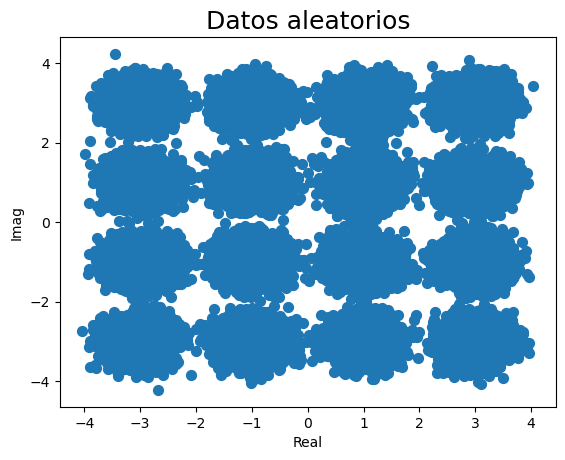

In [8]:
plt.scatter(Xr_ch, Xi_ch, s = 50, marker = 'o')
plt.title('Datos aleatorios', fontsize=18)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.show()

In [9]:
X = np.transpose(np.array([Xr_ch, Xi_ch]))

In [10]:
num_clusters = 16
cent_init = np.array([[-3,3], [-3,1], [-3,-3],[-3,-1],
                      [-1,3],[-1,1],[-1,-3],[-1,-1],
                      [3,3],[3,1],[3,-3],[3,-1],[1,3],
                      [1,1],[1,-3],[1,-1]])

model = KMeans(n_clusters = num_clusters, init = cent_init)
model.fit(X)

c:\Users\martinez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[-3,  3],
       [-3,  1],
       [-3, -3],
       [-3, -1],
       [-1,  3],
       [-1,  1],
       [-1, -3],
       [-1, -1],
       [ 3,  3],
       [ 3,  1],
       [ 3, -3],
       [ 3, -1],
       [ 1,  3],
       [ 1,  1],
       [ 1, -3],
       [ 1, -1]]),
       n_clusters=16)

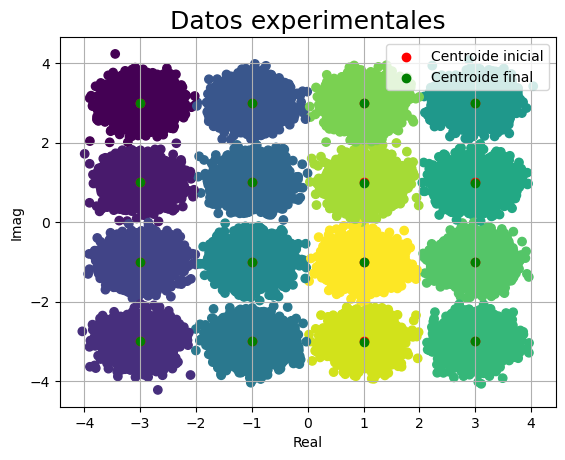

In [11]:
plt.scatter(X[:, 0], X[:, 1], c = model.labels_)
plt.scatter(cent_init[:, 0], cent_init[:, 1],
            label = 'Centroide inicial', marker = 'o', color = 'red')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1],
            label = 'Centroide final', marker = 'o', color = 'green')
plt.title('Datos experimentales', fontsize = 18)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

In [12]:
def SymbolErrorRate(sym_rx, sym_tx):
  error = 0
  for i, rx in enumerate(sym_rx):
    if rx != sym_tx[i]:
      error += 1
  SER = error / len(sym_tx)
  return SER, error

def BitErrorRate(sym_rx, sym_tx):
  sym_rx_bin = ''.join([f'{sym:04b}' for sym in sym_rx])
  sym_tx_bin = ''.join([f'{sym:04b}' for sym in sym_tx])

  error = 0
  for i in range(len(sym_tx_bin)):
    if sym_rx_bin[i] != sym_tx_bin[i]:
      error += 1
  BER = error / len(sym_tx_bin)
  return BER, error

def sync_signals1(trama_tx, trama_rx):
  tx = np.concatenate((trama_tx, trama_tx))
  corr = np.abs(np.correlate(np.abs(tx) - np.mean(np.abs(tx)),
                             np.abs(trama_rx) - np.mean(np.abs(trama_rx)), mode='full'))
  delay = np.argmax(corr) + 1 - len(trama_rx)
  print(f'El retraso es de {delay} posiciones')
  trama_sync = tx[delay:]
  trama_sync = trama_sync[:len(trama_rx)]
  return trama_sync

In [13]:
aux = sync_signals1(df_tx_mod['data'], df_rx_mod)

El retraso es de 70000 posiciones


In [14]:
y = []
for i in aux:
  if i == -3+3j:
    y.append(0)
  elif i == -3+1j:
    y.append(1)
  elif i == -3-3j:
    y.append(2)
  elif i == -3-1j:
    y.append(3)
  elif i == -1+3j:
    y.append(4)
  elif i == -1+1j:
    y.append(5)
  elif i == -1-3j:
    y.append(6)
  elif i == -1-1j:
    y.append(7)
  elif i == 3+3j:
    y.append(8)
  elif i == 3+1j:
    y.append(9)
  elif i == 3-3j:
    y.append(10)
  elif i == 3-1j:
    y.append(11)
  elif i == 1+3j:
    y.append(12)
  elif i == 1+1j:
    y.append(13)
  elif i == 1-3j:
    y.append(14)
  elif i == 1-1j:
    y.append(15)

In [15]:
BitErrorRate(model.labels_, y)

(0.00013333333333333334, 32)